# 9. 现代循环神经网络¶
前一章中我们介绍了循环神经网络的基础知识， 这种网络可以更好地处理序列数据。 我们在文本数据上实现了基于循环神经网络的语言模型， 但是对于当今各种各样的序列学习问题，这些技术可能并不够用。

例如，循环神经网络在实践中一个常见问题是数值不稳定性。 尽管我们已经应用了梯度裁剪等技巧来缓解这个问题， 但是仍需要通过设计更复杂的序列模型来进一步处理它。 具体来说，我们将引入两个广泛使用的网络， 即门控循环单元（gated recurrent units，GRU）和 长短期记忆网络（long short-term memory，LSTM）。 然后，我们将基于一个单向隐藏层来扩展循环神经网络架构。 我们将描述具有多个隐藏层的深层架构， 并讨论基于前向和后向循环计算的双向设计。 现代循环网络经常采用这种扩展。 在解释这些循环神经网络的变体时， 我们将继续考虑 8节中的语言建模问题。

事实上，语言建模只揭示了序列学习能力的冰山一角。 在各种序列学习问题中，如自动语音识别、文本到语音转换和机器翻译， 输入和输出都是任意长度的序列。 为了阐述如何拟合这种类型的数据， 我们将以机器翻译为例介绍基于循环神经网络的 “编码器－解码器”架构和束搜索，并用它们来生成序列。

# 门控循环单元（GRU）
:label:`sec_gru`

在 :numref:`sec_bptt`中，
我们讨论了如何在循环神经网络中计算梯度，
以及矩阵连续乘积可以导致梯度消失或梯度爆炸的问题。
下面我们简单思考一下这种梯度异常在实践中的意义：

* 我们可能会遇到这样的情况：早期观测值对预测所有未来观测值具有非常重要的意义。
  考虑一个极端情况，其中第一个观测值包含一个校验和，
  目标是在序列的末尾辨别校验和是否正确。
  在这种情况下，第一个词元的影响至关重要。
  我们希望有某些机制能够在一个记忆元里存储重要的早期信息。
  如果没有这样的机制，我们将不得不给这个观测值指定一个非常大的梯度，
  因为它会影响所有后续的观测值。
* 我们可能会遇到这样的情况：一些词元没有相关的观测值。
  例如，在对网页内容进行情感分析时，
  可能有一些辅助HTML代码与网页传达的情绪无关。
  我们希望有一些机制来*跳过*隐状态表示中的此类词元。
* 我们可能会遇到这样的情况：序列的各个部分之间存在逻辑中断。
  例如，书的章节之间可能会有过渡存在，
  或者证券的熊市和牛市之间可能会有过渡存在。
  在这种情况下，最好有一种方法来*重置*我们的内部状态表示。

在学术界已经提出了许多方法来解决这类问题。
其中最早的方法是"长短期记忆"（long-short-term memory，LSTM）
 :cite:`Hochreiter.Schmidhuber.1997`，
我们将在 :numref:`sec_lstm`中讨论。
门控循环单元（gated recurrent unit，GRU）
 :cite:`Cho.Van-Merrienboer.Bahdanau.ea.2014`
是一个稍微简化的变体，通常能够提供同等的效果，
并且计算 :cite:`Chung.Gulcehre.Cho.ea.2014`的速度明显更快。
由于门控循环单元更简单，我们从它开始解读。


## 门控隐状态

门控循环单元与普通的循环神经网络之间的关键区别在于：
前者支持隐状态的门控。
这意味着模型有专门的机制来确定应该何时更新隐状态，
以及应该何时重置隐状态。
这些机制是可学习的，并且能够解决了上面列出的问题。
例如，如果第一个词元非常重要，
模型将学会在第一次观测之后不更新隐状态。
同样，模型也可以学会跳过不相关的临时观测。
最后，模型还将学会在需要的时候重置隐状态。
下面我们将详细讨论各类门控。

### 重置门和更新门

我们首先介绍*重置门*（reset gate）和*更新门*（update gate）。
我们把它们设计成$(0, 1)$区间中的向量，
这样我们就可以进行凸组合。
重置门允许我们控制“可能还想记住”的过去状态的数量；
更新门将允许我们控制新状态中有多少个是旧状态的副本。

我们从构造这些门控开始。 :numref:`fig_gru_1`
描述了门控循环单元中的重置门和更新门的输入，
输入是由当前时间步的输入和前一时间步的隐状态给出。
两个门的输出是由使用sigmoid激活函数的两个全连接层给出。

总之，门控循环单元具有以下两个显著特征：

- 重置门有助于捕获序列中的短期依赖关系；

- 更新门有助于捕获序列中的长期依赖关系。

## 从零开始实现

为了更好地理解门控循环单元模型，我们从零开始实现它。
首先，我们读取 :numref:`sec_rnn_scratch`中使用的时间机器数据集：

In [1]:
import torch
from torch import nn
from d2l import torch as d2l


In [2]:
batch_size = 32
num_steps = 35

train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

### [**初始化模型参数**]

下一步是初始化模型参数。
我们从标准差为$0.01$的高斯分布中提取权重，
并将偏置项设为$0$，超参数`num_hiddens`定义隐藏单元的数量，
实例化与更新门、重置门、候选隐状态和输出层相关的所有权重和偏置。

In [3]:
def get_params(vocab_size, num_hiddens, device):
    
    num_inputs = num_outputs = vocab_size
    
    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                d2l.zeros(num_hiddens, device=device))

    W_xz, W_hz, b_z = three()  # 更新门参数
    W_xr, W_hr, b_r = three()  # 重置门参数
    W_xh, W_hh, b_h = three()  # 候选隐状态参数
    
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = d2l.zeros(num_outputs, device=device)
    
    # 附加梯度
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

### 定义模型

现在我们将[**定义隐状态的初始化函数**]`init_gru_state`。
与 :numref:`sec_rnn_scratch`中定义的`init_rnn_state`函数一样，
此函数返回一个形状为（批量大小，隐藏单元个数）的张量，张量的值全部为零。

In [4]:
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

现在我们准备[**定义门控循环单元模型**]，
模型的架构与基本的循环神经网络单元是相同的，
只是权重更新公式更为复杂。

In [5]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
        
    return torch.cat(outputs, dim=0), (H,)

### [**训练**]与预测

训练和预测的工作方式与 循环神经网络-从零开始 完全相同。
训练结束后，我们分别打印输出训练集的困惑度，
以及前缀“time traveler”和“traveler”的预测序列上的困惑度。

In [6]:
vocab_size = len(vocab)
num_hiddens = 256
device = d2l.try_gpu()


num_epochs = 500
lr = 1


model = d2l.RNNModelScratch(len(vocab), 
                            num_hiddens, 
                            device, 
                            get_params,
                            init_gru_state, 
                            gru
                           )

perplexity 1.1, 106379.4 tokens/sec on cuda:0
time traveller firer free incheng thicknos ane werhtwandlith sii
travelleryou can show black is white by argument said filby


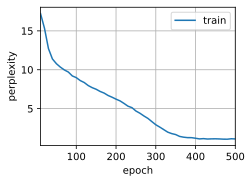

In [7]:

# 训练
d2l.train_ch8(model, 
              train_iter, 
              vocab, 
              lr, 
              num_epochs, 
              device)